1. <br>

A typical CNN is formed by interweaving different layer types, such as convolution layers, max pooling layers, typical NN layers and ReLU activation layers. Convolution layer is the fundamental of CNN. It captures the main features of the image input with an abstract representation. In torch.nn, each layer must be defined by `in_channels`, `out_channels`, `kernel_size` with optional parameters like `stride`, which will be discussed one by one. Each convolution layer is a 3D structure consists of _height_, _width_ and _depth_. It takes in `in_channels` numbers of input channels (e.g. 1 for greyscale, 3 for RBG color, `out_channels` from the last layer) and generates `out_channels` number of channels with different extracted features each, which is essentially the _depth_ of the layer. <br>
To extract these spatial features of the input, or to convolute the image, each channel applies a different filter. A filter is also a 3D structure consists of _height_, _width_ and _depth_. It is applied to each possible position of the input, filters the information from the input by performing dot product between filter parameters and features in the position. Thus, it is intuitive that the _filter depth_ equals the input channels (`in_channels`), and the output of the filter operation, the convolution layer, has a dimension of _layer height/width_ = _input height/width_ - _filter height/width_ + 1. The _height_ and _width_ of filters are uniformly described by `kernel_size`. Hence, with the application of filter, each layer provides a more abstracted version of the image input. Stacking up these convolution layers creates a feed-forward CNN. <br>
Some alternation can be applied in a convolution layer. Since calculating the cost product of each possible position can be costly, one can increase `stride` from 1 to 2 for instance to move the filter every 2 pixels. One can also use max pooling layers in the CNN, which takes the maximum value instead of dot product from each filter operation. <br>
2. <br>

The main advantage of CNN is it retains the spatial relationship in the image. With perceptron, the  _height_, _width_ and _depth_ of the image input are flattened before feeding into the network. This destroyed the innate relationship between neighbouring pixels and channel layers, thus losing information from input features. Meanwhile, in convolution, each layer preserves a similar 3D structure of the image and identifies the spatial characteristics of each image, for example a horizontal, vertical or diagonal pattern. Hence, it is expected that CNN provides better accuracy than MLP. Moreover, CNN provides better interpretability of the hyperparameters than MLP. `out_channels` specifies the number of general features to be extracted from the input; `kernel_size` defines the size hence clarity of each filter and the complexity of the output;  `stride` improves the efficiency of the neural network with minimum disregard of spatial features. <br>
3. <br>

ResNet is a CNN architecture characterised by shortcut connections between layers. Normal feedforward CNN usually comprises with few layers as convolution layers are costly to train and can easily overfit when the number of layers increases. Moreover, similar to MLP, feedforward CNN also subjects to vanishing gradient problem. ResNet can be considered as an ensemble technique that combines weakly dependent small networks with variable sizes. Similar to dropout, it reduces the entirety of the network by skipping some layers from time to time, which alleviates the exponential decay problem in feedforward neural networks. ResNet is also shown to provide high accuracy while maintaining efficiency even with many hidden layers. It has different variations, for instance the ResNet-18 used in this assignment consists of 18 layers. <br>

Reference: Liu, Tianyi, et al. "Towards understanding the importance of shortcut connections in residual networks." arXiv preprint arXiv:1909.04653 (2019).

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
# Training settings
batch_size = 64
test_batch_size = 1000
epochs = 14
lr = 1.0
gamma = 0.7
seed = 1
log_interval = 10
save_model = True
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

## Part 2: Load and Normalize [KMNIST](https://github.com/rois-codh/kmnist)


In [ ]:
import torchvision
import torchvision.transforms as transforms



transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize((0.5,), (0.5,))])
# train  set
train_val = torchvision.datasets.KMNIST('./', train=True, download=True, transform=transform)

train, val = torch.utils.data.random_split(train_val, [50000, 10000])
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=test_batch_size, shuffle=True)


# test set
test = torchvision.datasets.KMNIST('./', train=False, download=True,
                             transform=transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, shuffle=True)

### MLP model 



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU() # relu layer 
        self.fc2 = torch.nn.LogSoftmax(dim=1)
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = F.log_softmax(output, dim=1)
        return output

In [ ]:
# model define here
model = Feedforward(28*28, 128, 10)
model = model.to(device)

In [ ]:
# Optimizer 
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
# Define loss function
# negative log-likelihood is appropriate since log-softmax is used as activation funciton
criterion = nn.NLLLoss()

def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    loss_list_per_epoch = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # reshape data to be of shape batchsize \times 784 # 
        reshaped_size = data.view(data.size()[0], -1).size()
        data = torch.reshape(data, reshaped_size)

        # set the gradients to zero to avoid unwanted gradient accumulation, see 
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        optimizer.zero_grad()
        
        # get model prediction
        y_pred = model(data)

        loss = criterion(y_pred.squeeze(), target)

        # perform back propagation
        loss.backward()
        
        # update parameters
        optimizer.step() 
        
        if batch_idx % (log_interval*10) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        loss_list_per_epoch.append(loss.data)

    return loss_list_per_epoch

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          reshaped_size = data.view(data.size()[0], -1).size()
          data = torch.reshape(data, reshaped_size)
          
          output = model(data)
          _, preds = torch.max(output, 1)

          loss = criterion(output.squeeze(), target)
          
          test_loss += loss.item() * data.size()[0]
          correct += torch.sum(preds == target.data)

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)

In [ ]:
import time
MLP_loss_list = []
MLP_val_accuracy_list = []
start = time.time()
for epoch in range(1, epochs + 1):
    # train
    MLP_loss_list_per_epoch = train(model, device, train_loader, optimizer, epoch, log_interval)
    # inference on validation set 
    validation_loss, validation_accuracy = test(model, device, val_loader)
    scheduler.step()
    # log loss and acc
    MLP_loss_list += MLP_loss_list_per_epoch
    MLP_val_accuracy_list.append(validation_accuracy)

MLP_time = time.time() - start
print("Time required: {:.2f}".format(MLP_time))
if save_model:
    torch.save(model.state_dict(), "mnist_mlp.pt")

Train Epoch: 1 [0/50000 (0%)]	Loss: 4.964565
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.070926
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.434622
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.301493
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.056417
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.434343
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.140810
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.172325

Test set: Average loss: 1.4608, Accuracy: 6543/10000 (65%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.988957
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.343182
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.919880
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.094181
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.736434
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.126973
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.970497
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.802078

Test set: Average loss: 1.1779, Accuracy: 7216/10000 (72%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.988624
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.782

#### Visualize training progress

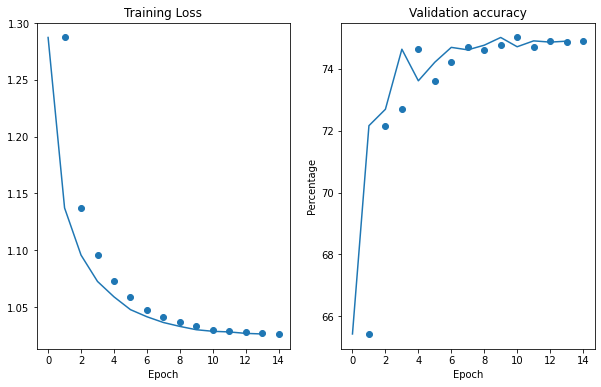

In [ ]:
#Visualize training process, by training loss and validation accuracy
# Take the average loss of each epoch for visualization
epoch_range = range(1, epochs + 1)
num_batches = -(-len(train_loader.dataset) // batch_size)
MLP_mean_loss = np.mean(np.array(MLP_loss_list).reshape(-1, num_batches), axis=1)
MLP_val_accuracy_list = np.array(MLP_val_accuracy_list)

plt.figure(figsize = (10,6))
plt.subplot(1, 2, 1)
plt.scatter(x = epoch_range, y = MLP_mean_loss)
plt.plot(MLP_mean_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.subplot(1, 2, 2)
plt.scatter(x = epoch_range, y = MLP_val_accuracy_list)
plt.plot(MLP_val_accuracy_list)
plt.title("Validation accuracy")
plt.ylabel("Percentage")
plt.xlabel("Epoch")
plt.show()

In [ ]:
test_loss, test_accuracy = test(model, device, test_loader)


Test set: Average loss: 1.5008, Accuracy: 6425/10000 (64%)



Class-wise accuracy

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = torch.zeros(10)
    class_total = torch.zeros(10)
    class_correct = class_correct.to(device)
    class_total = class_total.to(device)
    with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          reshaped_size = data.view(data.size()[0], -1).size()
          data = torch.reshape(data, reshaped_size)
          
          output = model(data)
          _, preds = torch.max(output, 1)

          loss = criterion(output.squeeze(), target)
          
          test_loss += loss.item() * data.size()[0]
          correct += torch.sum(preds == target.data)
          for i in range(10):
            class_correct[i] += torch.sum((preds == target.data) & (preds == i))
            class_total[i] += torch.sum(target.data == i)

    test_loss /= len(test_loader.dataset)
    class_accuracy = torch.divide(class_correct, class_total)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset), class_accuracy

In [ ]:
test_loss, test_accuracy, test_class_accuracy = test(model, device, test_loader)


Test set: Average loss: 1.5008, Accuracy: 6425/10000 (64%)



In [ ]:
for i, acc in enumerate(test_class_accuracy):
  print("Class {} Accuracy: {:.0f}%\n".format(i, acc*100))

Class 0 Accuracy: 82%

Class 1 Accuracy: 70%

Class 2 Accuracy: 68%

Class 3 Accuracy: 79%

Class 4 Accuracy: 66%

Class 5 Accuracy: 74%

Class 6 Accuracy: 74%

Class 7 Accuracy: 62%

Class 8 Accuracy: 0%

Class 9 Accuracy: 68%



### Simple CNN model

In [ ]:
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
# define the model, optimizer and scheduler
model = CNN_Net()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #SGD is used as optimizer
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

# loss function
# since the activation function is also log-softmax, we continue to use log-negattive likelihood as loss function
criterion = nn.NLLLoss()


In [ ]:
# modify the training and testing function
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    loss_list_per_epoch = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # set the gradients to zero to avoid unwanted gradient accumulation, see 
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        optimizer.zero_grad()
        
        # get model prediction
        y_pred = model(data)
        loss = criterion(y_pred.squeeze(), target)

        # perform back propagation
        loss.backward()
        
        # update parameters
        optimizer.step() 
        
        if batch_idx % (log_interval*10) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        loss_list_per_epoch.append(loss.data)

    return loss_list_per_epoch

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = torch.zeros(10)
    class_total = torch.zeros(10)
    class_correct = class_correct.to(device)
    class_total = class_total.to(device)
    with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          
          output = model(data)
          _, preds = torch.max(output, 1)

          loss = criterion(output.squeeze(), target)
          
          test_loss += loss.item() * data.size()[0]
          correct += torch.sum(preds == target.data)
          for i in range(10):
            class_correct[i] += torch.sum((preds == target.data) & (preds == i))
            class_total[i] += torch.sum(target.data == i)

    test_loss /= len(test_loader.dataset)
    class_accuracy = torch.divide(class_correct, class_total)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset), class_accuracy

In [ ]:
#train the model and test the validation performance each epoch
CNN_loss_list = []
CNN_val_accuracy_list = []
start = time.time()
for epoch in range(1, epochs + 1):
    # train
    loss_list_per_epoch = train(model, device, train_loader, optimizer, epoch, log_interval)
    # inference on validation set 
    validation_loss, validation_accuracy, validation_class_accuracy= test(model, device, val_loader)
    scheduler.step()
    # log loss and acc
    CNN_loss_list += loss_list_per_epoch
    CNN_val_accuracy_list.append(validation_accuracy)
CNN_time = time.time() - start
print("Time required: {:.2f}".format(CNN_time))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.300021
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.961367
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.141769
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.882941
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.709077
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.856148
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.787100
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.686889

Test set: Average loss: 0.5121, Accuracy: 8465/10000 (85%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.697409
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.798328
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.628424
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.484344
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.597992
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.441089
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.763457
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.460579

Test set: Average loss: 0.3730, Accuracy: 8872/10000 (89%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.642499
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.441

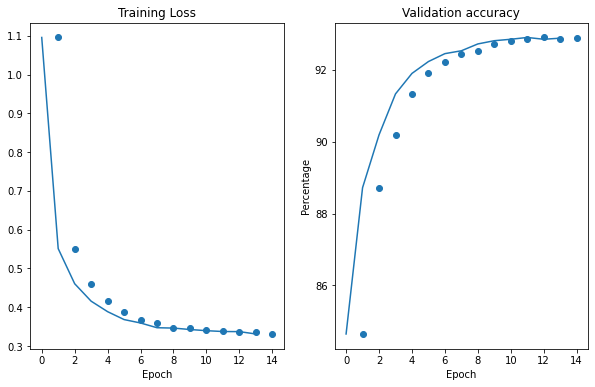

In [ ]:
#Visualize training process, by training loss and validation accuracy
# Take the average loss of each epoch for visualization
epoch_range = range(1, epochs + 1)
num_batches = -(-len(train_loader.dataset) // batch_size)
CNN_mean_loss = np.mean(np.array(CNN_loss_list).reshape(-1, num_batches), axis=1)
CNN_val_accuracy_list = np.array(CNN_val_accuracy_list)

plt.figure(figsize = (10,6))
plt.subplot(1, 2, 1)
plt.scatter(x = epoch_range, y = CNN_mean_loss)
plt.plot(CNN_mean_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.subplot(1, 2, 2)
plt.scatter(x = epoch_range, y = CNN_val_accuracy_list)
plt.plot(CNN_val_accuracy_list)
plt.title("Validation accuracy")
plt.ylabel("Percentage")
plt.xlabel("Epoch")
plt.show()

In [ ]:
# Test set results
print("Test set results")
test_loss, test_accuracy, test_class_accuracy = test(model, device, test_loader)
for i, acc in enumerate(test_class_accuracy):
  print("Class {} Accuracy: {:.0f}%\n".format(i, acc*100))

Test set results

Test set: Average loss: 0.5279, Accuracy: 8352/10000 (84%)

Class 0 Accuracy: 85%

Class 1 Accuracy: 82%

Class 2 Accuracy: 79%

Class 3 Accuracy: 92%

Class 4 Accuracy: 81%

Class 5 Accuracy: 81%

Class 6 Accuracy: 86%

Class 7 Accuracy: 82%

Class 8 Accuracy: 87%

Class 9 Accuracy: 82%



### Use ResNet from torchvision

In [ ]:
from torchvision.models import resnet18
from torch import nn
model = resnet18(num_classes=10) # MNIST has 10 classes

In [ ]:
#Configure the model, optimizer and scheduler
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7))
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #lower learning rate than the previous two as to fine-tune the model instead of building from scratch
exp_lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# reload the functions as criterion and hyperparameters are changed
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    loss_list_per_epoch = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # set the gradients to zero to avoid unwanted gradient accumulation, see 
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        optimizer.zero_grad()
        
        # get model prediction
        y_pred = model(data)
        
        loss = criterion(y_pred.squeeze(), target)

        # perform back propagation
        loss.backward()
        
        # update parameters
        optimizer.step() 
        
        if batch_idx % (log_interval*10) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        loss_list_per_epoch.append(loss.data)

    return loss_list_per_epoch

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = torch.zeros(10)
    class_total = torch.zeros(10)
    class_correct = class_correct.to(device)
    class_total = class_total.to(device)
    with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          
          output = model(data)
          _, preds = torch.max(output, 1)

          loss = criterion(output.squeeze(), target)
          
          test_loss += loss.item() * data.size()[0]
          correct += torch.sum(preds == target.data)
          for i in range(10):
            class_correct[i] += torch.sum((preds == target.data) & (preds == i))
            class_total[i] += torch.sum(target.data == i)

    test_loss /= len(test_loader.dataset)
    class_accuracy = torch.divide(class_correct, class_total)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset), class_accuracy

In [ ]:
#train the model and test the validation performance each epoch
RN_loss_list = []
RN_val_accuracy_list = []
start = time.time()
for epoch in range(1, epochs + 1):
    # train
    loss_list_per_epoch = train(model, device, train_loader, optimizer, epoch, log_interval)
    # inference on validation set 
    validation_loss, validation_accuracy, validation_class_accuracy= test(model, device, val_loader)
    scheduler.step()
    # log loss and acc
    RN_loss_list += loss_list_per_epoch
    RN_val_accuracy_list.append(validation_accuracy)

RN_time = time.time() - start
print("Time required: {:.2f}".format(RN_time))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.433568
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.880111
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.644915
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.492468
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.298349
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.203593
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.148525
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.181860

Test set: Average loss: 0.1691, Accuracy: 9504/10000 (95%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.100907
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.114146
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.134267
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.069058
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.097180
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.205509
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.050402
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.084751

Test set: Average loss: 0.1093, Accuracy: 9670/10000 (97%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.034592
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.026

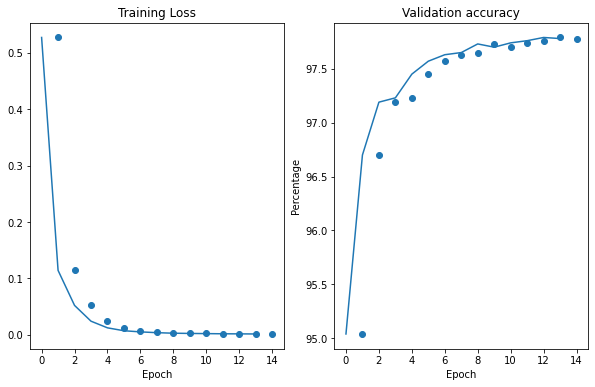

In [ ]:
#Visualize training process, by training loss and validation accuracy
# Take the average loss of each epoch for visualization
epoch_range = range(1, epochs + 1)
num_batches = -(-len(train_loader.dataset) // batch_size)
RN_mean_loss = np.mean(np.array(RN_loss_list).reshape(-1, num_batches), axis=1)
RN_val_accuracy_list = np.array(RN_val_accuracy_list)

plt.figure(figsize = (10,6))
plt.subplot(1, 2, 1)
plt.scatter(x = epoch_range, y = RN_mean_loss)
plt.plot(RN_mean_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.subplot(1, 2, 2)
plt.scatter(x = epoch_range, y = RN_val_accuracy_list)
plt.plot(RN_val_accuracy_list)
plt.title("Validation accuracy")
plt.ylabel("Percentage")
plt.xlabel("Epoch")
plt.show()

In [ ]:
# Test set results
print("Test set results")
test_loss, test_accuracy, test_class_accuracy = test(model, device, test_loader)
for i, acc in enumerate(test_class_accuracy):
  print("Class {} Accuracy: {:.0f}%\n".format(i, acc*100))

Test set results

Test set: Average loss: 0.2869, Accuracy: 9306/10000 (93%)

Class 0 Accuracy: 95%

Class 1 Accuracy: 91%

Class 2 Accuracy: 87%

Class 3 Accuracy: 96%

Class 4 Accuracy: 92%

Class 5 Accuracy: 91%

Class 6 Accuracy: 96%

Class 7 Accuracy: 92%

Class 8 Accuracy: 97%

Class 9 Accuracy: 95%



The accuracies of MLP, CNN and RN on testing set are 64%, 84% and 93% respectively. As described in part one MLP destroyed the spatial relationship between features hence it is foreseeable to produce the lowest accuracy. ResNet has the highest accuracy due to its more sophisticated architecture with more layers while prevented from overfitting and vanishing gradient descent. However, ResNet requires about 3 times the time of MLP and CNN with the same number of epochs. It is more costly to train a ResNet model due to its greater depth.

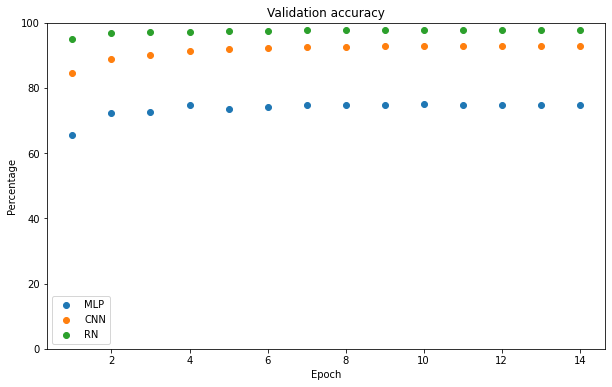

In [ ]:
epoch_range = range(1, epochs + 1)
plt.figure(figsize = (10,6))
plt.scatter(x = epoch_range, y = MLP_val_accuracy_list, label = "MLP")
plt.scatter(x = epoch_range, y = CNN_val_accuracy_list, label = "CNN")
plt.scatter(x = epoch_range, y = RN_val_accuracy_list, label = "RN")
plt.ylim((0,100))
plt.title("Validation accuracy")
plt.ylabel("Percentage")
plt.xlabel("Epoch")
plt.legend()
plt.show()